In [1]:
# Picking a training and validation set that minimizes KL-divergence
# of the tag distributions relative the full dataset.
%load_ext autoreload
%autoreload 2
%matplotlib inline
from scipy.stats import entropy
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl

import sys; sys.path.append('..')
from planet.utils.data_utils import tagstr_to_binary, TAGS, get_train_val_idxs

print('Done')

Done


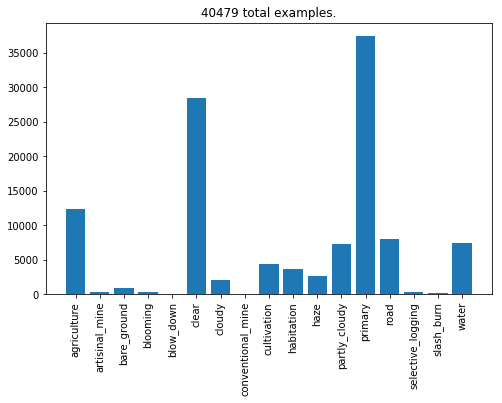

[ 0.30423182  0.00837471  0.02129499  0.00820178  0.00242101  0.70236419
  0.05160701  0.00247042  0.11060056  0.09041725  0.06662714  0.17937696
  0.92672744  0.19938734  0.00839942  0.00516317  0.18308259]
Done


In [2]:
# Read data and convert text labels to vectors.
df = pd.read_csv('../data/train_v2.csv')
tags_binary = np.vstack([tagstr_to_binary(ts) for ts in df['tags'].values])

# Compute, plot normalized distribution.
dist = np.sum(tags_binary, axis=0)
plt.figure(figsize=(8,5))
plt.bar(np.arange(len(dist)), dist)
plt.xticks(np.arange(len(dist)), TAGS, rotation='vertical')
plt.title('%d total examples.' % df.shape[0])
plt.show()

dist_norm =  dist / tags_binary.shape[0]
print(dist_norm)
print('Done')

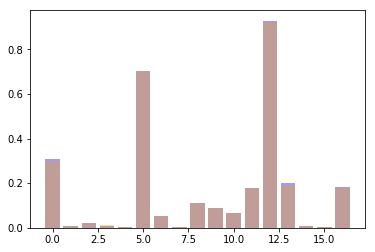

[ 0.00896449 -0.00080261 -0.00055518 -0.00302595 -0.00098807  0.00097896
 -0.00373484  0.00030887  0.00176355  0.00247316 -0.00132577  0.00405077
  0.0047532   0.01099931 -0.00092613 -0.00080271  0.00698445]


In [8]:
idxs_trn, idxs_val = get_train_val_idxs('../data/train-jpg.hdf5', nb_iter=10)
dist_trn = np.sum(tags_binary[idxs_trn], axis=0) / len(idxs_trn)
dist_val = np.sum(tags_binary[idxs_val], axis=0) / len(idxs_val)
plt.bar(range(len(dist_trn)), dist_trn, color='blue', alpha=0.4)
plt.bar(range(len(dist_val)), dist_val, color='orange', alpha=0.4)
plt.show()
print(dist_trn - dist_val)